In [1]:
# !pip install --upgrade scipy

In [2]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import soundfile as sf
import os 
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

In [4]:


pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = False

if on_colab:
  from google.colab import drive
  project_name = 'project_name'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './data/input/'
  output_dir = './data/output/'

os.makedirs(output_dir, exist_ok=True)



In [5]:
audio_files = os.listdir(input_dir+'audios_16khz/')
audio_files.sort()

In [6]:
# audio_files_speech = [n for n in audio_files if 'Speech_' in n]

In [7]:
import librosa

df = pd.read_csv(input_dir+'features/egemaps_vector_both.csv', index_col = 0)
display(df['token'].value_counts())
print(df.shape)

duration_d = {}

files = os.listdir(input_dir+'audios_16khz/')


for sid, token, target, filename in df[['sid', 'token','target', 'filename']].values:
    
    filename2 = filename.replace('Speech', 'Speech_') 
    
    try: 
        duration = librosa.get_duration(filename=input_dir+f'audios_16khz/{filename2}.wav', sr=16000) 
        duration_d[filename] = [sid, token, target,duration]
    except:
        print(f'{filename}.wav not found')


duration_df = pd.DataFrame(duration_d, index = ['sid', 'token', 'target', 'duration']).T

duration_df['task']  = [n[:-1] for n in duration_df['token'].values]
display(duration_df['token'].value_counts())
display(duration_df['task'].value_counts())
duration_df = duration_df.reset_index()
duration_df.columns = ['filename', 'sid', 'token', 'target', 'duration', 'task']
duration_df


Vowel1     152
Vowel3     152
Speech1    151
Speech2    151
Speech3    151
Vowel2     151
Vowel1N      1
Vowel2N      1
Vowel3N      1
Name: token, dtype: int64

(911, 92)
VFP52_Vowel1N.wav not found
VFP52_Vowel2N.wav not found
VFP52_Vowel3N.wav not found


Vowel1     152
Vowel3     152
Speech1    151
Speech2    151
Speech3    151
Vowel2     151
Name: token, dtype: int64

Vowel     455
Speech    453
Name: task, dtype: int64

,filename,sid,token,target,duration,task
0,VFP10_Speech1,VFP10,Speech1,1,3.503,Speech
1,VFP10_Speech2,VFP10,Speech2,1,3.503,Speech
2,VFP10_Speech3,VFP10,Speech3,1,3.503,Speech
3,VFP11_Speech1,VFP11,Speech1,1,3.503,Speech
4,VFP11_Speech2,VFP11,Speech2,1,3.503,Speech
...,...,...,...,...,...,...
903,VFPNorm8_Vowel2,VFPNorm8,Vowel2,0,4.109,Vowel
904,VFPNorm8_Vowel3,VFPNorm8,Vowel3,0,4.11,Vowel
905,VFPNorm9_Vowel1,VFPNorm9,Vowel1,0,4.11,Vowel
906,VFPNorm9_Vowel2,VFPNorm9,Vowel2,0,4.11,Vowel


# Mean and SD for audio duration

In [8]:
means = duration_df.groupby(['task', 'target']).mean().round(2)



# stds = duration_df.groupby(['task', 'target']).std().round(2)
# display(stds)
display(means)


# duration_df[duration_df['target']==1].groupby('task')['duration'].std()

duration_df.groupby(['task', 'target'])['duration'].std()

/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


duration
task   target          
Speech 0           3.50
       1          10.25
Vowel  0           4.11
       1           3.74

task    target
Speech  0         0.000000
        1         6.168351
Vowel   0         0.064770
        1         1.300837
Name: duration, dtype: float64

# Plot audio duration histogram

No handles with labels found to put in legend.


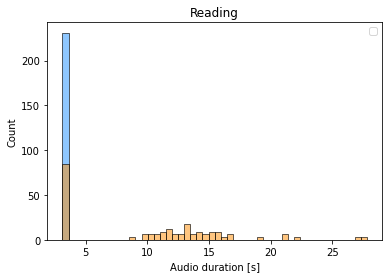

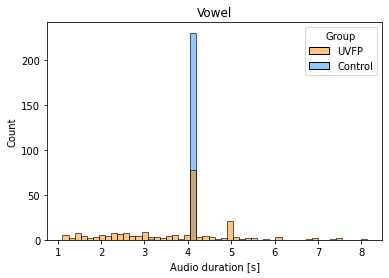

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
duration_df['Group'] = duration_df['target'].map({0: 'Control', 1: 'UVFP'})
duration_df_speech = duration_df[duration_df['task']=='Speech']
# plt.hist(x='duration', color='orange', data=duration_df_speech[duration_df_speech['Group']=='Control'], bins=50, alpha=0.5)
# plt.hist(x='duration', color='dodgerblue', data=duration_df_speech[duration_df_speech['Group']=='UVFP'], bins=50, alpha=0.5)



sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Speech'], bins=50, palette=["darkorange", "dodgerblue"])
plt.xlabel('Audio duration [s]')
# plt.axvline(x=3.5,color = 'darkorange', label = 'Mean')
# plt.legend()
plt.title('Reading')
plt.legend()
plt.savefig(output_dir+'duration_hist_speech.png', dpi=300)
plt.show()


sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Vowel'], bins=50, palette=["darkorange", "dodgerblue"])
plt.xlabel('Audio duration [s]')
plt.title('Vowel')
plt.savefig(output_dir+'duration_hist_vowel.png', dpi=300)
plt.show()

# Look at full speech files

Speech    151
Name: token, dtype: int64

Speech    151
Name: task, dtype: int64

,filename,sid,token,target,duration,task
0,VFPNorm51_Speech.wav,VFPNorm51,Speech,0,10.51,Speech
1,VFPNorm66_Speech.wav,VFPNorm66,Speech,0,10.51,Speech
2,VFPNorm33_Speech.wav,VFPNorm33,Speech,0,10.509,Speech
3,VFP58_Speech.wav,VFP58,Speech,1,10.51,Speech
4,VFPNorm18_Speech.wav,VFPNorm18,Speech,0,10.509,Speech
...,...,...,...,...,...,...
146,VFP28_Speech.wav,VFP28,Speech,1,35.953562,Speech
147,VFPNorm68_Speech.wav,VFPNorm68,Speech,0,10.51,Speech
148,VFP34_Speech.wav,VFP34,Speech,1,29.256625,Speech
149,VFP56_Speech.wav,VFP56,Speech,1,34.077438,Speech


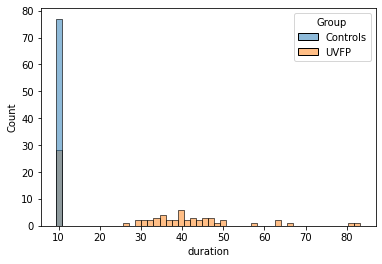

In [10]:
full_speech_files = [n for n in files if 'Speech.wav' in n]
duration_d = {}

for filename in full_speech_files:
    duration = librosa.get_duration(filename=input_dir+f'audios_16khz/{filename}', sr=16000) 
    sid = filename.split('_')[0]
    token = filename.split('_')[1]
    token = token.replace('.wav', '')
    if 'VFPNorm' in filename:
        target = 0
    else:
        target = 1
    
    duration_d[filename] = [sid, token, target,duration]


duration_df = pd.DataFrame(duration_d, index = ['sid', 'token', 'target', 'duration']).T

duration_df['task']  = duration_df['token'].values
display(duration_df['token'].value_counts())
display(duration_df['task'].value_counts())
duration_df = duration_df.reset_index()
duration_df.columns = ['filename', 'sid', 'token', 'target', 'duration', 'task']
display(duration_df)


duration_df['Group'] = duration_df['target'].map({0: 'Controls', 1: 'UVFP'})
sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Speech'], bins=50)


plt.show()

# sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Vowel'], bins=100)
# plt.show()




In [11]:
import librosa

df = pd.read_csv(input_dir+'features/egemaps_vector_both.csv', index_col = 0)
display(df['token'].value_counts())
print(df.shape)

duration_d = {}

files = os.listdir(input_dir+'audios_16khz/')



for sid, token, target, filename in df[['sid', 'token','target', 'filename']].values:
    
    filename2 = filename.replace('Speech', 'Speech_') 
    
    try: 
        duration = librosa.get_duration(filename=input_dir+f'audios_16khz/{filename2}.wav', sr=16000) 
        duration_d[filename] = [sid, token, target,duration]
    except:
        print(f'{filename}.wav not found')


duration_df = pd.DataFrame(duration_d, index = ['sid', 'token', 'target', 'duration']).T

duration_df['task']  = [n[:-1] for n in duration_df['token'].values]
display(duration_df['token'].value_counts())
display(duration_df['task'].value_counts())
duration_df = duration_df.reset_index()
duration_df.columns = ['filename', 'sid', 'token', 'target', 'duration', 'task']
duration_df


Vowel1     152
Vowel3     152
Speech1    151
Speech2    151
Speech3    151
Vowel2     151
Vowel1N      1
Vowel2N      1
Vowel3N      1
Name: token, dtype: int64

(911, 92)
VFP52_Vowel1N.wav not found
VFP52_Vowel2N.wav not found
VFP52_Vowel3N.wav not found


Vowel1     152
Vowel3     152
Speech1    151
Speech2    151
Speech3    151
Vowel2     151
Name: token, dtype: int64

Vowel     455
Speech    453
Name: task, dtype: int64

,filename,sid,token,target,duration,task
0,VFP10_Speech1,VFP10,Speech1,1,3.503,Speech
1,VFP10_Speech2,VFP10,Speech2,1,3.503,Speech
2,VFP10_Speech3,VFP10,Speech3,1,3.503,Speech
3,VFP11_Speech1,VFP11,Speech1,1,3.503,Speech
4,VFP11_Speech2,VFP11,Speech2,1,3.503,Speech
...,...,...,...,...,...,...
903,VFPNorm8_Vowel2,VFPNorm8,Vowel2,0,4.109,Vowel
904,VFPNorm8_Vowel3,VFPNorm8,Vowel3,0,4.11,Vowel
905,VFPNorm9_Vowel1,VFPNorm9,Vowel1,0,4.11,Vowel
906,VFPNorm9_Vowel2,VFPNorm9,Vowel2,0,4.11,Vowel


### Add to egemaps features DF

In [12]:
# egemaps features
egemaps_filenames = ['egemaps_vector_both.csv',
                    'egemaps_vector_speech.csv',
                    'egemaps_vector_vowel.csv'
                   ]

egemaps_features_df = {}
for i in egemaps_filenames:
    df_i = pd.read_csv(input_dir+'features/'+i, index_col = 0)
    egemaps_features_df[i]=df_i
    

In [13]:
duration_df

,filename,sid,token,target,duration,task
0,VFP10_Speech1,VFP10,Speech1,1,3.503,Speech
1,VFP10_Speech2,VFP10,Speech2,1,3.503,Speech
2,VFP10_Speech3,VFP10,Speech3,1,3.503,Speech
3,VFP11_Speech1,VFP11,Speech1,1,3.503,Speech
4,VFP11_Speech2,VFP11,Speech2,1,3.503,Speech
...,...,...,...,...,...,...
903,VFPNorm8_Vowel2,VFPNorm8,Vowel2,0,4.109,Vowel
904,VFPNorm8_Vowel3,VFPNorm8,Vowel3,0,4.11,Vowel
905,VFPNorm9_Vowel1,VFPNorm9,Vowel1,0,4.11,Vowel
906,VFPNorm9_Vowel2,VFPNorm9,Vowel2,0,4.11,Vowel


In [14]:
for filename, df_i in egemaps_features_df.items():
    df_i_duration = df_i.merge(duration_df[['filename', 'duration', 'task']], on = ['filename'], how='inner')
    df_i_duration.to_csv(input_dir+'features/'+filename.replace('.csv', '_duration.csv'))
    
    

# Bootstrapping classification

In [15]:

models = [
    LogisticRegressionCV(solver='liblinear', penalty = 'l1', max_iter = 100),
    SGDClassifier(loss='log', penalty="elasticnet", early_stopping=True, max_iter = 5000),
    MLPClassifier(alpha = 1, max_iter= 1000),
    RandomForestClassifier(n_estimators= 100)
]


names = ['LogisticRegressionCV', 'SGDClassifier', "MLPClassifier","RandomForestClassifier"]

In [17]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics

In [44]:
%%time

toy = True

duration_df = duration_df.sample(frac=1)

os.makedirs(output_dir+f'duration/', exist_ok=True)

for df_name, task_type_df in zip(['speech', 'vowel', 'both'], [
    'egemaps_vector_speech_duration.csv',
    'egemaps_vector_vowel_duration.csv', 
    'egemaps_vector_both_duration.csv']):
    duration_df = pd.read_csv(input_dir+f'features/{task_type_df}', index_col = 0)
    print(df_name, '\n====')

    for null_model in [True, False]:
        print('\npermute', null_model)
    
        if toy:
          n_bootstraps = 3
        else:
          n_bootstraps = 50

        variables = ['duration']
        X = duration_df[variables].values
        y = duration_df['target'].values
        groups = duration_df['sid'].values
        if null_model:
            y = np.random.permutation(y) #CHECK
        

        y_pred_all = {}
        accuracy_all = {}
        roc_auc_all = {}
        for model, name in zip(models, names):
          y_pred_all[name] = []
          roc_auc_all[name] = []
          pipe = Pipeline(steps=[
                  ('scaler', StandardScaler()), 
                  ('model', model)])

          ## Performing bootstrapping
          
          splitter = GroupShuffleSplit(n_splits=50, test_size=0.2, random_state=42)

          y_test_all = []

          for i, (train_index, test_index) in enumerate(splitter.split(X, y, groups)):

              X_train, X_test = X[train_index], X[test_index]
              y_train, y_test = y[train_index], y[test_index]
              


              pipe.fit(X_train,y_train)

              # Test     
              
              # Evaluate
              y_proba = model.predict_proba(X_test)       # Get predicted probabilities
              y_proba_1 = y_proba[:,1]
              y_pred = y_proba_1>=0.5*1                   # define your threshold
              accuracy = metrics.accuracy_score(y_test, y_pred)
              roc_auc = metrics.roc_auc_score(y_test, y_proba_1)  # IMPORTANT: other metrics take binary predictions y_pred. Here we test different thresholds, so we need probabilities (this will change the ROC AUC score)
              
              # print(name, roc_auc)
              y_pred_all[name].append(y_pred)
              accuracy_all[name].append(accuracy)
              roc_auc_all[name].append(roc_auc)

        results_i = []
        for name in ['LogisticRegressionCV','MLPClassifier','RandomForestClassifier','SGDClassifier']:
          scores = roc_auc_all.get(name)
          roc_auc_median = np.round(np.median(scores),2)
          roc_auc_5 = np.round(np.percentile(scores, 5),2)
          roc_auc_95 = np.round(np.percentile(scores, 95),2)
          results_str = f'{roc_auc_median} ({roc_auc_5}–{roc_auc_95}; )'
          results_str = results_str.replace('0.', '.')
          results_i.append([name, results_str])
            
          if null_model:
            print(name, str(roc_auc_median).replace('0.', '.'))
        if not null_model:
            results_i_df = pd.DataFrame(results_i, ).T
            display(results_i_df)

            results_i_df.to_csv(output_dir+f'duration/results_duration_{df_name}_permute-{null_model}.csv')

            
                

        # pd.DataFrame(y_pred_all)


speech 
====

permute True


NameError: name 'metrics' is not defined

In [34]:
duration_df = duration_df.sample(frac=1)
X = duration_df[variables].values
y = duration_df['target'].values
groups = duration_df['sid'].values






In [41]:
# Make sure splits are different and no duplicates
display(pd.DataFrame(y_test_all))
print()
print('50?', pd.DataFrame(y_test_all).drop_duplicates(keep='first').shape)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185
0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,1,1,1,0,1,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,1,0,1,0,1,1,0,1,1,0,0,0,1,0,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0,1,1,0,0,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,1,0,1,1,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN
4,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,1,0,0,0,1,1,1,0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
5,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
6,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
7,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,1,1,1,0,1,1,0,1,1

50? (50, 186)
